In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
import pandas as pd

train_df_v1 = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test_df_v1  = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

# Modelling Steps
1. Checking for Correlation
2. Imputing NAs
3. Splitting the DataFrame
4. Encoding
5. Scaling
6. Dimensionality Reduction
7. Regression Models
8. Cross-Validating Model
9. Saving the Model
10. SHAP


# Check for Correlations b/w two features & b/w feature & target. Drop redundant features.


In [3]:
correlation_matrix = train_df_v1.corr(numeric_only = True)
threshold = 0.8
# Unstack correlation matrix and filter
corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Remove self-correlation (correlation of a feature with itself)
corr_pairs = corr_pairs[corr_pairs < 1]

# Drop duplicate pairs (since matrix is symmetric)
strong_corr = corr_pairs[~corr_pairs.duplicated()]

# Filter strong correlations
strong_corr = strong_corr[strong_corr > threshold]
print(strong_corr)

GarageArea   GarageCars      0.882475
GarageYrBlt  YearBuilt       0.825667
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
dtype: float64


In [4]:
train_df_v1 = train_df_v1.drop(columns = ['GarageCars', 'GarageYrBlt'])

In [5]:
correlation_with_target = train_df_v1.corr(numeric_only = True)['SalePrice'].drop('SalePrice').sort_values(ascending = False)
# print(correlation_with_target)

In [6]:
# PoolArea         0.092404
# MoSold           0.046432
# 3SsnPorch        0.044584
# BsmtFinSF2      -0.011378
# BsmtHalfBath    -0.016844
# MiscVal         -0.021190
# Id              -0.021917
# LowQualFinSF    -0.025606
# YrSold          -0.028923
# OverallCond     -0.077856
# MSSubClass      -0.084284

least_correlated_to_target = ['PoolArea', 'MoSold', '3SsnPorch', 'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass']

train_df_v1 = train_df_v1.drop(columns = least_correlated_to_target)

In [7]:
train_df_v1.shape

(1460, 69)

# Impute NAs

In [8]:
train_df_v1.columns[train_df_v1.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

In [9]:
df_imputed = train_df_v1.copy()

for col in df_imputed.columns:
    if df_imputed[col].dtypes == 'object':
        df_imputed[col] = df_imputed[col].fillna('No')
    else:
        df_imputed[col] = df_imputed[col].fillna(0)

In [10]:
df_imputed.columns[df_imputed.isnull().any()]

Index([], dtype='object')

# Split into Train & Test

In [11]:
X = df_imputed.drop(columns = 'SalePrice')
y = df_imputed['SalePrice']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Encoding

In [13]:
obj_cols = X_train.select_dtypes(include = 'object').columns
X_train  = pd.get_dummies(X_train, columns = obj_cols)
X_test = pd.get_dummies(X_test, columns = obj_cols)

missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

X_test = X_test[X_train.columns]

# Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

original_numeric_columns = X.select_dtypes(include = ['int64', 'float64']).columns

scaler = StandardScaler()

X_train_scaled_num = pd.DataFrame(scaler.fit_transform(X_train[original_numeric_columns]), columns = original_numeric_columns, index = X_train.index)
X_test_scaled_num = pd.DataFrame(scaler.transform(X_test[original_numeric_columns]), columns = original_numeric_columns, index = X_test.index)

encoded_cols = X_train.columns.difference(original_numeric_columns)

X_train_scaled = pd.concat([X_train_scaled_num, X_train[encoded_cols]], axis = 1)
X_test_scaled = pd.concat([X_test_scaled_num, X_test[encoded_cols]], axis = 1)

# Dimensionality Reduction using PCA

In [15]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_

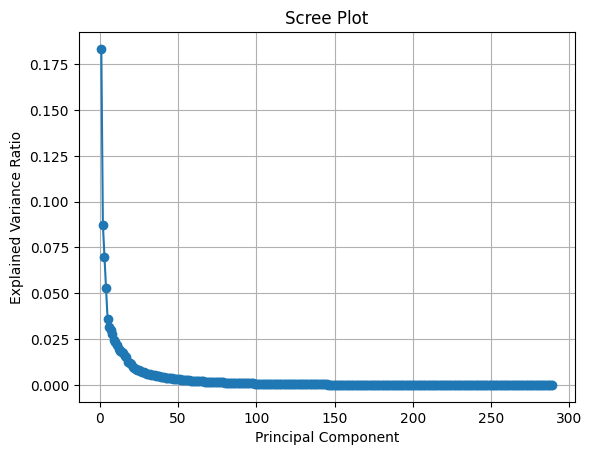

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [17]:
pca = PCA(n_components = 15)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
X_train_pca.shape
X_test_pca.shape

(292, 15)

# Regression Models
* LinearRegression
* DecisionTreeRegressor
* RandomForestRegressor
* SVR (Support Vector Regression)
* KNeighborsRegressor

# Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_train_pca, y_train)

y_pred = linear_model.predict(X_test_pca)

In [20]:
#Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [21]:
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 1428931743.5721936
RMSE: 37801.213519835495
MAE: 22768.176700878295
R2: 0.8137065223858042


# Adding Regularization

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {
    'alpha' : [0.01, 0.1, 1, 10, 100] 
}

grid_search = GridSearchCV(estimator = ridge, param_grid = param_grid, cv = 5, scoring = 'r2')

grid_search.fit(X_train_pca, y_train)

print(f"Best Alpha:", grid_search.best_params_)
print(f"Best R2 score:", grid_search.best_score_)

Best Alpha: {'alpha': 100}
Best R2 score: 0.7762739011050785


In [23]:
best_model = grid_search.best_estimator_
print(f"Test R2 Score:", best_model.score(X_test_pca, y_test))

Test R2 Score: 0.8118166268768098


In [24]:
y_linear_reg_pred = grid_search.predict(X_test_pca)

mse = mean_squared_error(y_test, y_linear_reg_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_linear_reg_pred)
r2 = r2_score(y_test, y_linear_reg_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 1443427858.6236792
RMSE: 37992.47107814493
MAE: 22694.162657165474
R2: 0.8118166268768098


# DecisionTree Regression

In [25]:
# Applying DecisionTree Regressor without Scaling & PCA
from sklearn.tree import DecisionTreeRegressor

params = {
    'max_depth' : [3, 5, 7],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

grid = GridSearchCV(DecisionTreeRegressor(), params, scoring = 'r2', cv = 5)

grid.fit(X_train, y_train)

print(f"Best params: ", grid.best_params_)
print(f"Best R2 Score: ", grid.best_score_)

Best params:  {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best R2 Score:  0.7041184675875508


In [26]:
regressor = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 4, min_samples_split = 10, random_state = 42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(f"R2 Score: ", r2_score(y_test, y_pred))

R2 Score:  0.8119135183432383


# RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf' : [1, 2]
}

rf = RandomForestRegressor(random_state = 42)

grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, scoring = 'r2')

grid.fit(X_train, y_train)

print(f"Best Parameters: ", grid.best_params_)
print(f"Best R2 Score: ", grid.best_score_)

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best R2 Score:  0.8395299190159513


In [28]:
best_rf_model = grid.best_estimator_
y_pred = best_rf_model.predict(X_test)

print(f"R2 Score: ", r2_score(y_test, y_pred))

R2 Score:  0.887946985881946


# XGBoost

In [29]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators' : [100, 200],
    'learning_rate' : [0.05, 0.1],
    'max_depth' : [3, 5]
}

xgb = XGBRegressor(random_state = 42)

grid = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, scoring = 'r2', verbose = 1)

grid.fit(X_train, y_train)

print("Best Parameters: ", grid.best_params_)
print("Best R2 Score: ", grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best R2 Score:  0.8587637372973591


In [30]:
best_model = grid.best_estimator_
y_pred = grid.predict(X_test)

print("R2 Score: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))

R2 Score:  0.9013737865701049
MSE:  756495229.5869552
RMSE:  27504.45835836356
MAE:  17430.52635380993


# Cross-Validating the Model

In [31]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train, y_train, cv = 5, scoring = 'r2')
print("CV R2 Mean: ", cv_scores.mean())
print("CV R2 Std: ",cv_scores.std())

CV R2 Mean:  0.8587637372973591
CV R2 Std:  0.030215557190885946


# Saving the Model

In [32]:
import joblib

#Save
joblib.dump(best_model, 'xgboost_model.pkl')

#Load
loaded_model = joblib.load('xgboost_model.pkl')

# SHAP

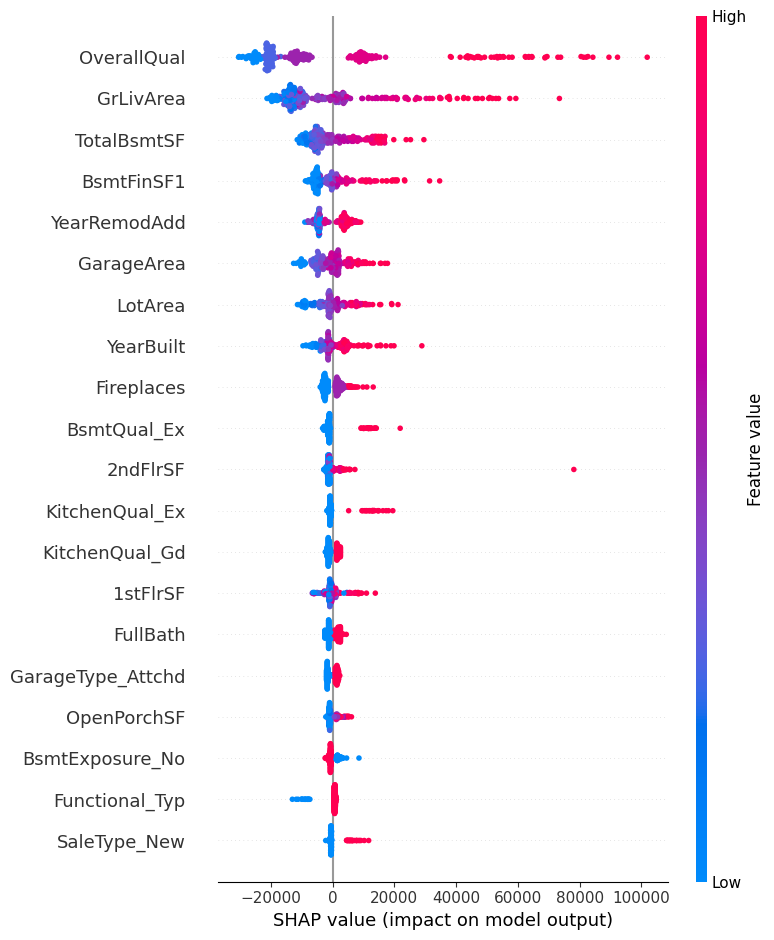

In [33]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)